In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

import fm2p
import imgtools

Loading DLC 2.3.0...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\.conda\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [ ]:
topvid = fm2p.pack_video_frames(r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\fm1\fm1_0002.mp4', dwnsmpl=0.5)
topdown_tracking_h5 = r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\fm1\250306_DMM_DMM038_pillar_fm1_0002DLC_Resnet50_trackbar-v5Mar1shuffle1_snapshot_190.h5'

Reading fm1_0002.mp4


100%|██████████| 12063/12063 [01:55<00:00, 104.25it/s]


Reading 250306_DMM_DMM038_fm_1_eyecam.avi


100%|██████████| 48784/48784 [00:18<00:00, 2703.60it/s]
<tifffile.TiffFile 'file_00001.tif'> <asarray> failed to reshape (12063, 512, 512) to (30000, 512, 512), raised ValueError('cannot reshape array of size 3162243072 into shape (30000,512,512)')


Registering image stack to template.


100%|██████████| 12063/12063 [05:34<00:00, 36.11it/s]


In [639]:
eyevid = fm2p.pack_video_frames(r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\fm1\250306_DMM_DMM038_fm_1_eyecam_deinter.avi')[eyeT_startInd:eyeT_endInd]

Reading 250306_DMM_DMM038_fm_1_eyecam_deinter.avi


100%|██████████| 97568/97568 [01:48<00:00, 898.21it/s]


In [565]:
twop_path = r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\fm1\file_00001.tif'
twop_stack = imgtools.load_tif_stack(twop_path, rotate=False, ds=1.0, doReg=False, doNorm=False)

<tifffile.TiffFile 'file_00001.tif'> <asarray> failed to reshape (12063, 512, 512) to (30000, 512, 512), raised ValueError('cannot reshape array of size 3162243072 into shape (30000,512,512)')


In [3]:
cfg = r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\preprocessed_config.yaml'
rname = 'fm1'

if type(cfg)==str:
    with open(cfg, 'r') as infile:
        cfg = yaml.load(infile, Loader=yaml.FullLoader)
rcfg = cfg[rname]

rpath = rcfg['rpath']
eye_data = fm2p.read_h5(rcfg['eye_preproc_path'])
top_data = fm2p.read_h5(rcfg['top_preproc_path'])
twop_data = fm2p.read_h5(rcfg['twop_preproc_path'])
eyeT_startInd = rcfg['eyeT_startInd']
eyeT_endInd = rcfg['eyeT_endInd']

# Two photon data
sps = twop_data['s2p_spks']
raw_dFF = twop_data['raw_dFF']
twop_dt = 1./cfg['twop_rate']
twopT = np.arange(0, np.size(sps, 1)*twop_dt, twop_dt)

# Eyecam data
eyeT = eye_data['eyeT'][eyeT_startInd:eyeT_endInd]
theta_raw = eye_data['theta'][eyeT_startInd:eyeT_endInd]
phi_raw = eye_data['phi'][eyeT_startInd:eyeT_endInd]
puprad_raw = eye_data['longaxis'][eyeT_startInd:eyeT_endInd]

# Interpolate eyecam data to twop and topdown data
eyeT = eyeT.copy() - eyeT[0]

theta = fm2p.interpT(theta_raw, eyeT, twopT, fill_consecutive=True)
phi = fm2p.interpT(phi_raw, eyeT, twopT, fill_consecutive=True)
puprad = fm2p.interpT(puprad_raw, eyeT, twopT, fill_consecutive=True)

# Topcam data
pxls2cm = top_data['pxls2cm']
speed = top_data['speed']
# Animal yaw is defined so that 0 deg is rightward in the raw video, 90 deg is downward in the raw
# video, and angles wrap from 0 to 360 deg clockwise.
yaw = top_data['head_yaw_deg']
movement_yaw = top_data['movement_yaw_deg']
top_x = top_data['x']
top_y = top_data['y']
top_xdisp = top_data['x_displacement']
top_ydisp = top_data['y_displacement']
learx = top_data['lear_x']
leary = top_data['lear_y']
rearx = top_data['rear_x']
reary = top_data['rear_y']

In [50]:
import cv2

In [93]:
def norm(x):
    norm_x = x.copy()
    norm_x = norm_x - np.nanmin(norm_x)
    norm_x = norm_x / np.nanmax(norm_x)
    return norm_x

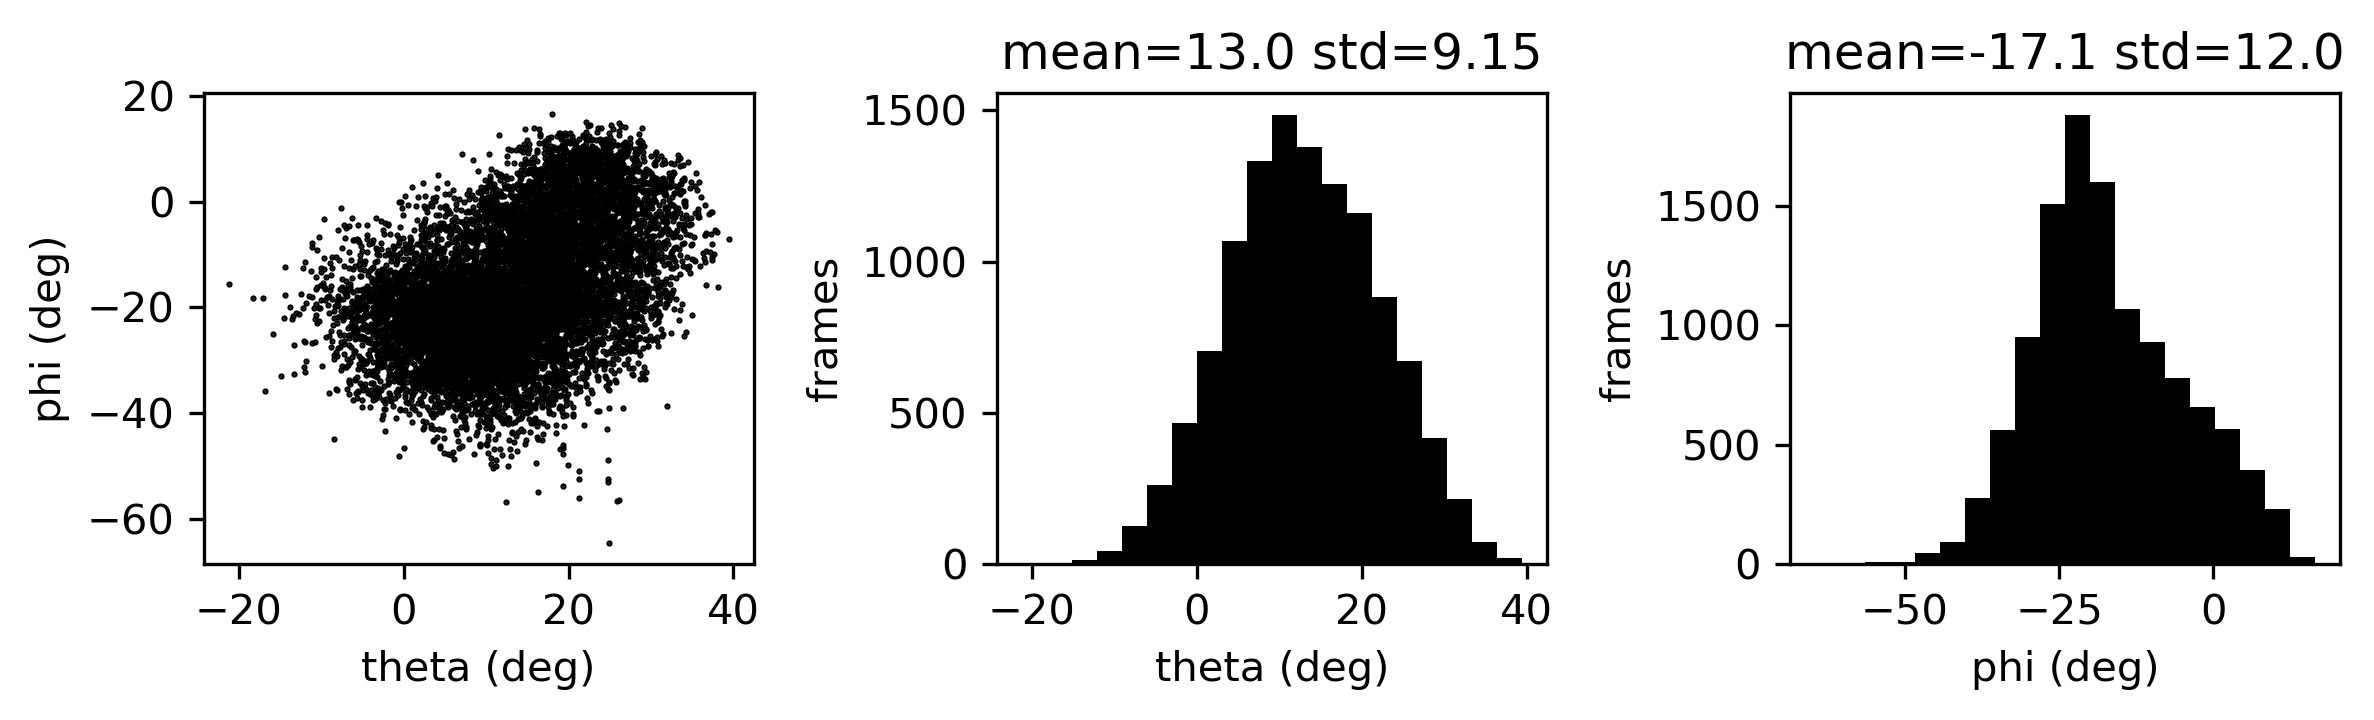

In [116]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(8,2.5), dpi=300)

ax1.plot(np.rad2deg(theta), np.rad2deg(phi), 'k.', ms=1)
ax1.set_xlabel('theta (deg)')
ax1.set_ylabel('phi (deg)')

ax2.hist(np.rad2deg(theta), color='k', bins=20)
ax2.set_xlabel('theta (deg)')
ax2.set_ylabel('frames')
ax2.set_title('mean={:.3} std={:.3}'.format(np.nanmean(np.rad2deg(theta)), np.nanstd(np.rad2deg(theta))))

ax3.hist(np.rad2deg(phi), color='k', bins=20)
ax3.set_xlabel('phi (deg)')
ax3.set_ylabel('frames')
ax3.set_title('mean={:.3} std={:.3}'.format(np.nanmean(np.rad2deg(phi)), np.nanstd(np.rad2deg(phi))))

fig.tight_layout()

In [146]:
eye_dlc_h5 = r'C:\Data\dylan\Mini2P_data\250306_DMM_DMM038_pillar\fm1\250306_DMM_DMM038_fm_1_eyecam_deinterDLC_resnet50_freely_moving_eyecams_02Feb12shuffle1_100000.h5'

xyl, _ = fm2p.open_dlc_h5(eye_dlc_h5)
x_vals, y_vals, likelihood = fm2p.split_xyl(xyl)

likelihood = likelihood[eyeT_startInd:eyeT_endInd]

# Threshold by number of sucessfully tracked pupil points
pupil_count = np.sum(likelihood >= 0.99, 1)

usegood_eye = pupil_count >= 7

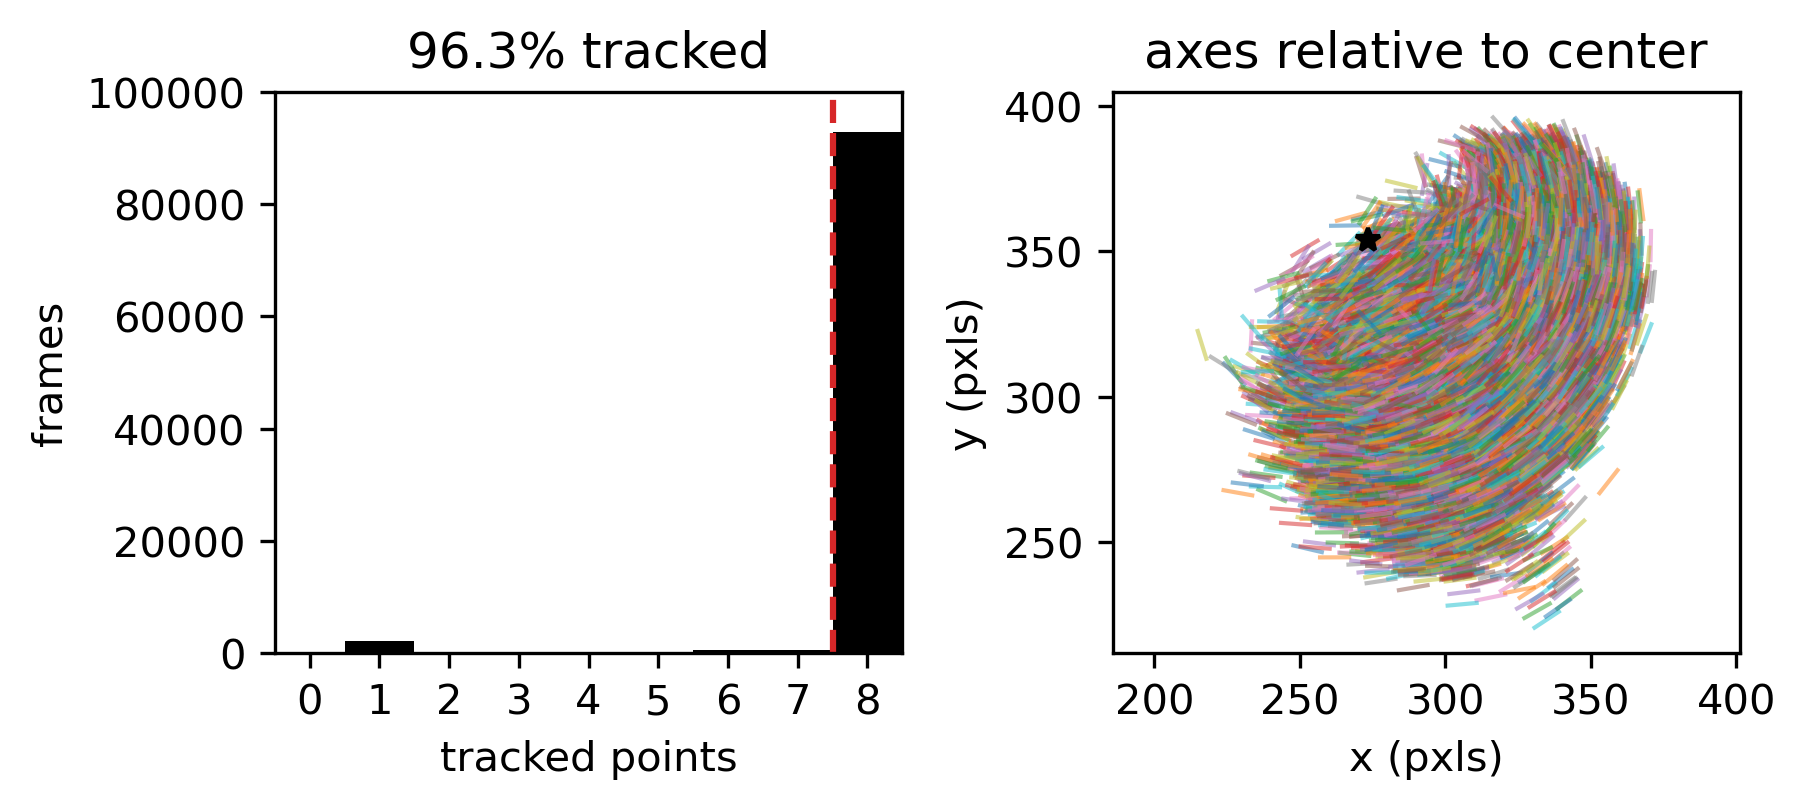

In [150]:
fig, [ax0,ax1] = plt.subplots(1,2, figsize=(6,2.8), dpi=300)

ax0.hist(pupil_count, bins=8, color='k')
ax0.set_xlabel('tracked points')
ax0.set_ylabel('frames')
ax0.vlines(7, 0, 100000, ls='--', color='tab:red')
ax0.set_xticks(np.arange(-0.5,8.5,1), labels=np.arange(0,9))
ax0.set_xlim([-1, 8])
ax0.set_ylim([0, 100000])
ax0.set_title('{:.3}% tracked'.format(np.mean(usegood_eye)*100))

w = eye_data['ellipse_phi']
X0 = eye_data['X0']
Y0 = eye_data['Y0']
for i in np.arange(len(eye_data['ellipse_phi']))[::2]:

    ax1.plot((X0[i] + [-5 * np.cos(w[i]), 5*np.cos(w[i])]), (Y0[i] + [-5*np.sin(w[i]), 5*np.sin(w[i])]), lw=1, alpha=0.5)

ax1.plot(eye_data['cam_center_x'], eye_data['cam_center_y'], 'k*', label='camera center')
ax1.set_title('axes relative to center')
ax1.axis('equal')
ax1.set_xlabel('x (pxls)')
ax1.set_ylabel('y (pxls)')
# ax1.legend(fontsize=7)

fig.tight_layout()

In [534]:
import math
def angle_to_target(x_c, y_c, heading, x_t, y_t):
    
    # Calculate the absolute angle to the target relative to the eastern horizontal
    absolute_angle = math.degrees(math.atan2(y_t - y_c, x_t - x_c))
    
    # Normalize absolute angle to [0, 360)
    absolute_angle = (absolute_angle + 360) % 360
    
    # Normalize heading to [0, 360)
    heading = (heading + 360) % 360  

    # Calculate the smallest angle difference (-180 to 180)
    angle_difference = (absolute_angle - heading + 180) % 360 - 180

    return absolute_angle, angle_difference

In [535]:
headx = np.array([np.mean([rearx[f], learx[f]]) for f in range(len(rearx))])
heady = np.array([np.mean([reary[f], leary[f]]) for f in range(len(reary))])
pillarx = 830
pillary = 515

pillar_ego = np.zeros_like(headx) * np.nan
pillar_abs = np.zeros_like(headx) * np.nan

for f in range(len(headx)):
    pillar_abs[f], pillar_ego[f] = angle_to_target(headx[f], heady[f], yaw[f], pillarx, pillary)

# distance
# pillar_d = np.array([np.sqrt((pillarx-headx[f])**2+(pillary-heady[f])**2) for f in range(len(headx))])
# # angle from horizontal to to pillar
# pillar_c = np.array([np.tan((pillarx-headx[f]) / pillar_d[f]) for f in range(len(headx))])
# # add yaw to get angle from head to pillar
# pillar_ego = np.array([pillar_c[f] + np.deg2rad(yaw[f]) for f in range(len(yaw))]) # + (np.pi*1.5)

(array([1071., 1146., 1046.,  821.,  842.,  777.,  788.,  960., 1114.,
         920.]),
 array([1.05863532e-02, 3.60067042e+01, 7.20028221e+01, 1.07998940e+02,
        1.43995058e+02, 1.79991176e+02, 2.15987293e+02, 2.51983411e+02,
        2.87979529e+02, 3.23975647e+02, 3.59971765e+02]),
 <BarContainer object of 10 artists>)

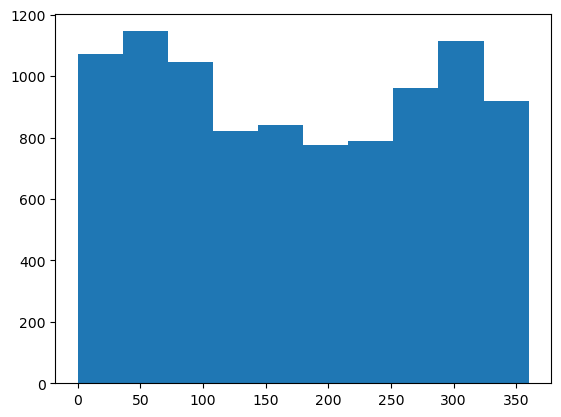

In [539]:
plt.hist(yaw)

(array([1062.,  983., 1135.,  865.,  920.,  755.,  851.,  990.,  935.,
         989.]),
 array([-1.79930101e+02, -1.43943179e+02, -1.07956258e+02, -7.19693358e+01,
        -3.59824141e+01,  4.50768513e-03,  3.59914294e+01,  7.19783512e+01,
         1.07965273e+02,  1.43952195e+02,  1.79939116e+02]),
 <BarContainer object of 10 artists>)

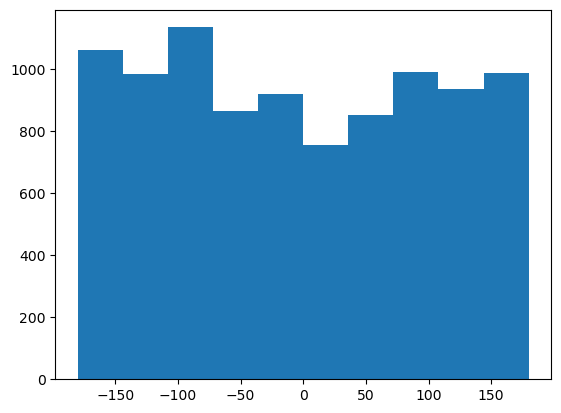

In [540]:
plt.hist(pillar_ego)

In [567]:
topvid[f].shape

(1024, 1224)

284.6989653780656


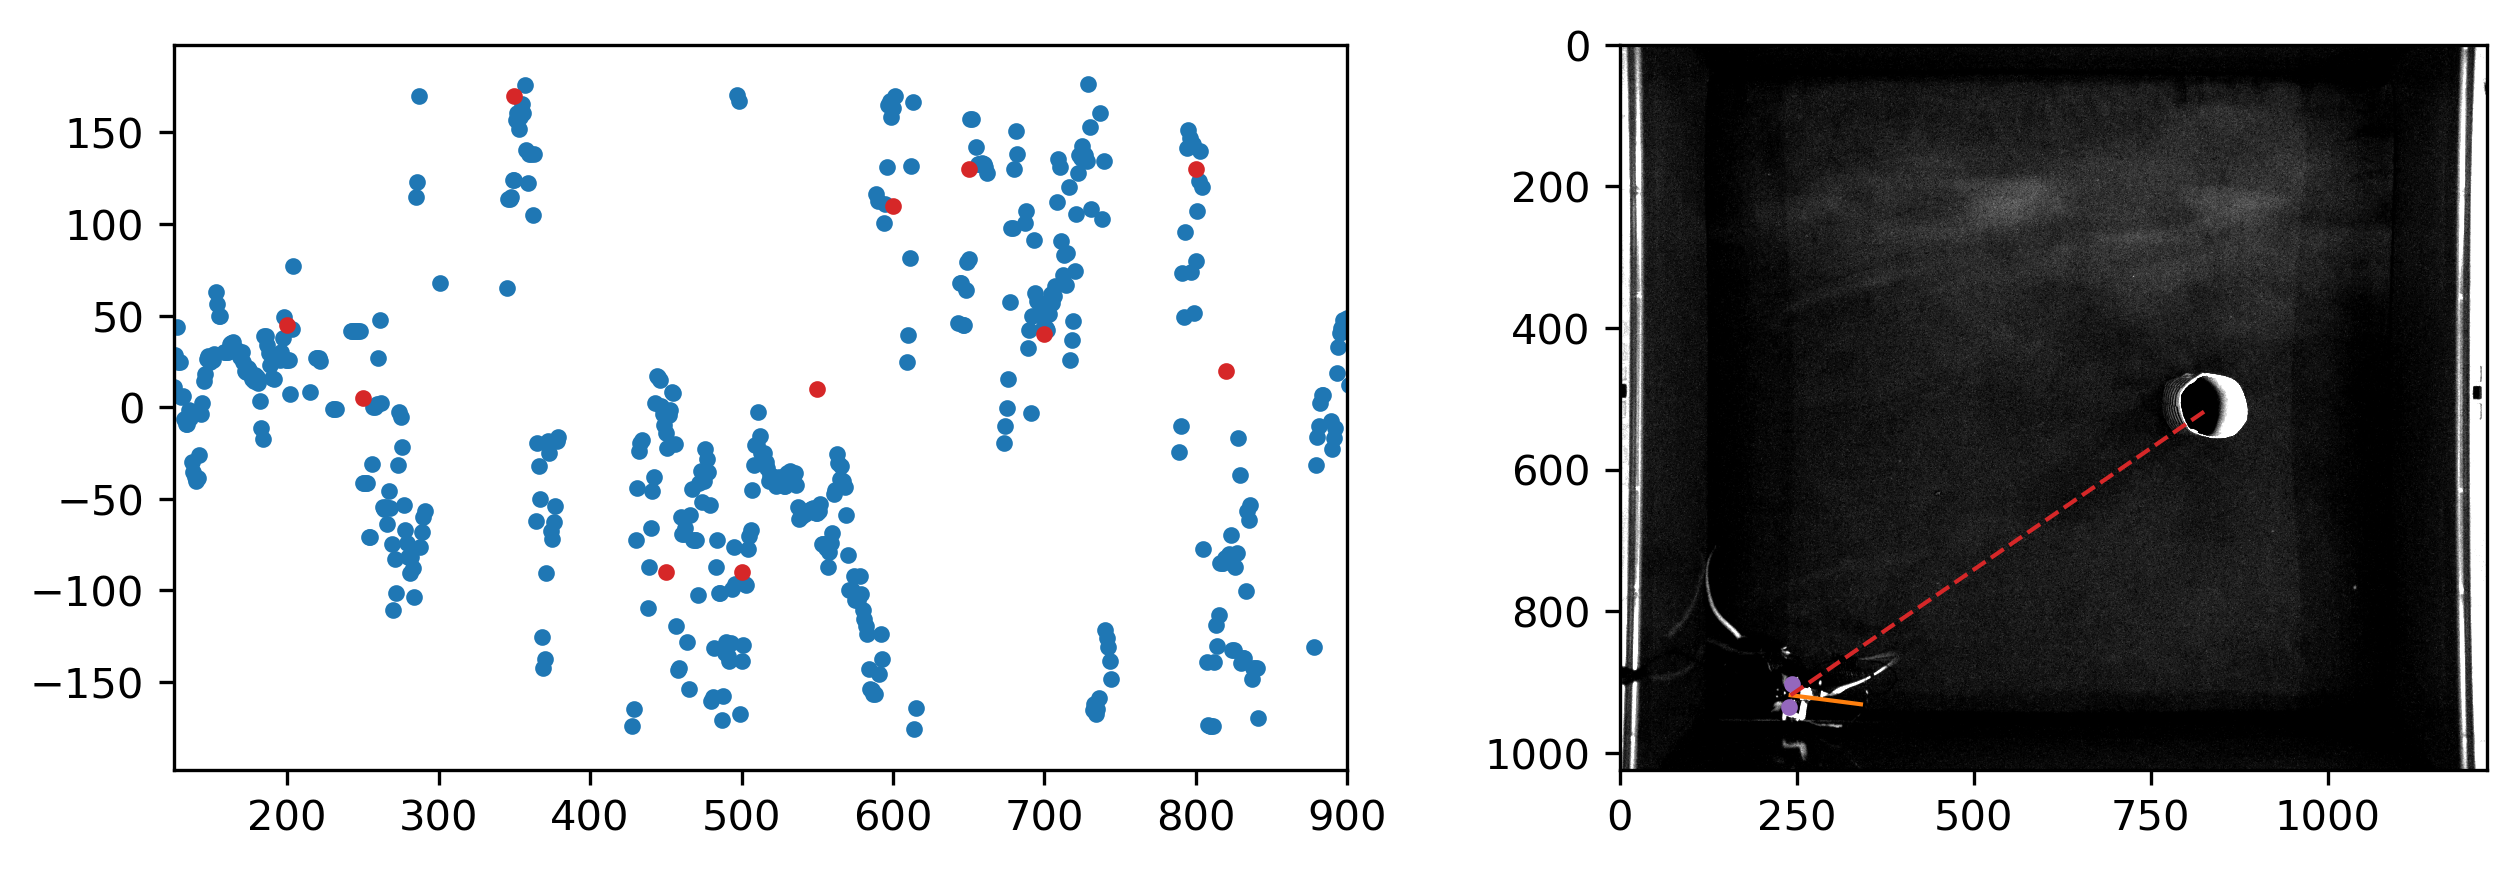

In [569]:
f = 820
fig, [ax1,ax2] = plt.subplots(1,2, dpi=300, figsize=(9,3))
# pillar_ego2 = (pillar_ego-np.deg2rad(yaw)+(np.pi/2))%(np.pi*2)

ax1.plot(pillar_ego, '.')
ax1.set_xlim([125,900])
# ax1.set_ylim([-360,360])
ax1.plot([350, 250, 200, 450, 500, 550, 600, 650, 700, 800, 820],
         [170, 5, 45, -90, -90, 10, 110, 130, 40, 130, 20],
         '.', color='tab:red')

scale = 0.5
ax2.imshow(topvid[f], cmap='gray', vmin=0, vmax=75)
ax2.plot(rearx[f]*scale, reary[f]*scale, '.', color='tab:purple')
ax2.plot(learx[f]*scale, leary[f]*scale, '.', color='tab:purple')
headx, heady = np.mean([rearx[f]*scale, learx[f]*scale]), np.mean([reary[f]*scale, leary[f]*scale])
ax2.plot([headx, headx+100*np.cos(np.deg2rad(yaw[f]))],
         [heady, heady+100*np.sin(np.deg2rad(yaw[f]))],
         '-', lw=1, color='tab:orange')
ax2.set_xlim([0,1224])
ax2.set_ylim([1024,0])
ax2.plot([headx, pillarx], [heady, pillary], '--', lw=1, color='tab:red')
fig.tight_layout()
print(pillar_abs[f])

-18.824172109823365


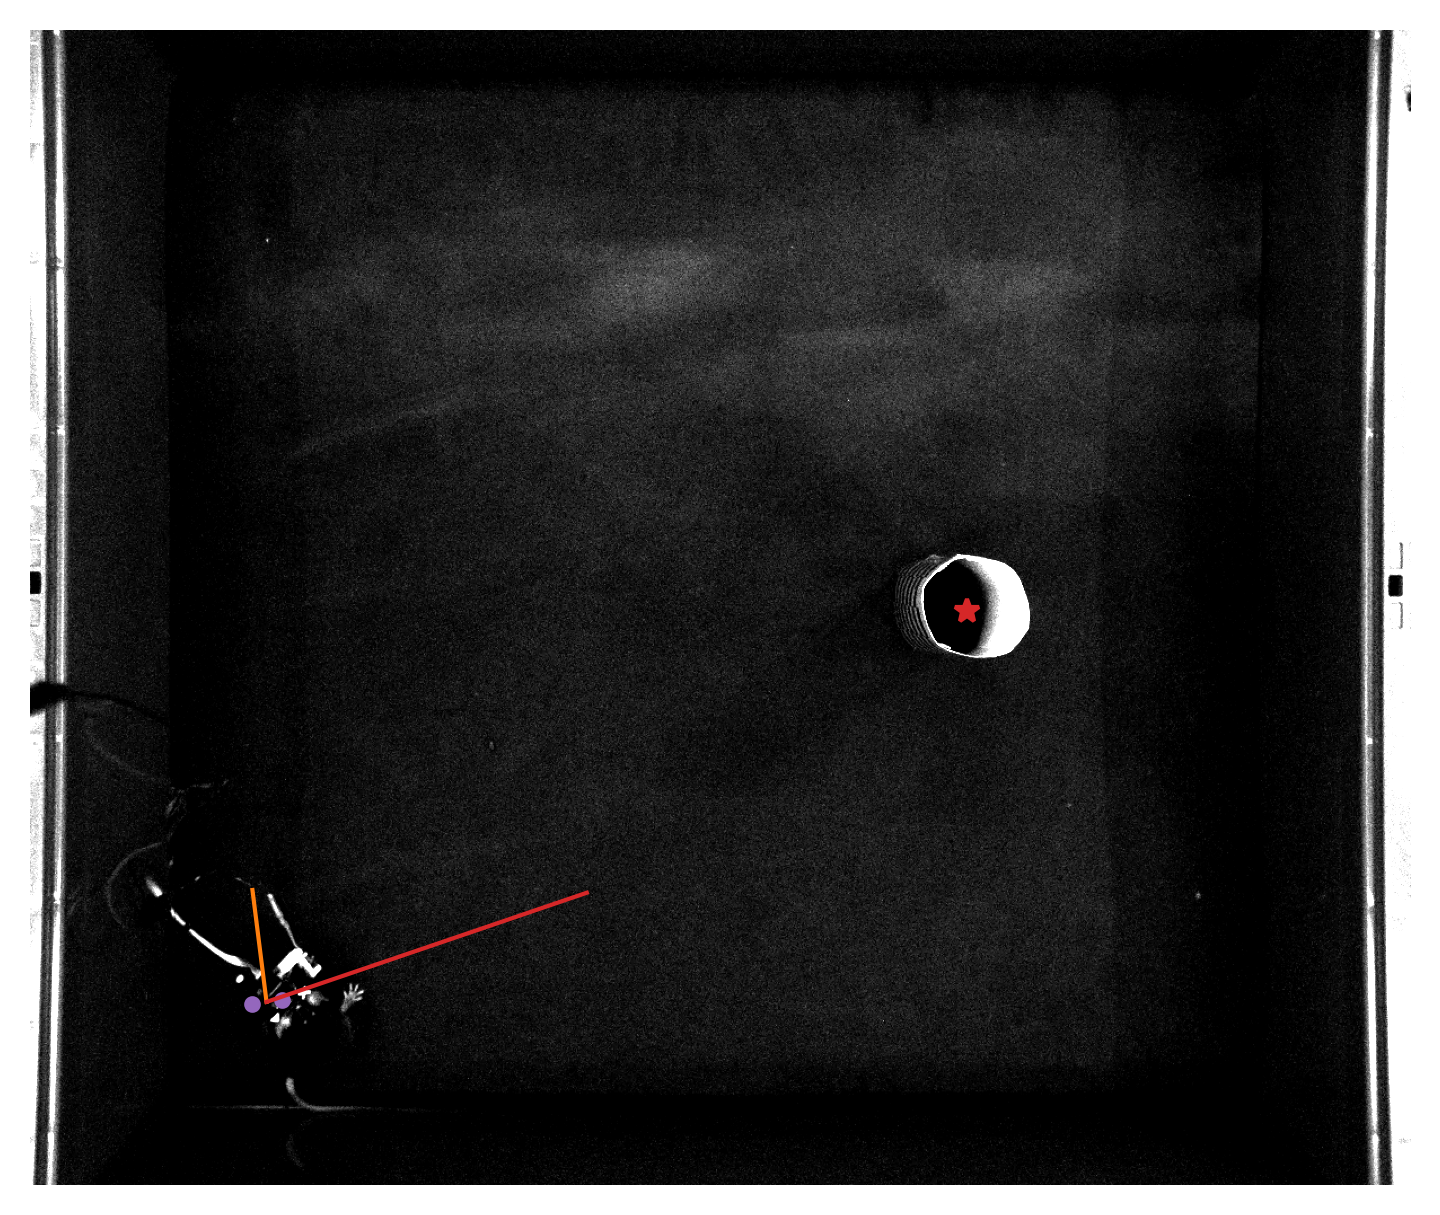

In [416]:
scale = 0.5
f = 200

pillar_ego1 = pillar_ego.copy() - np.pi

fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=300)
ax.imshow(topvid[f], cmap='gray', vmin=0, vmax=75)
ax.plot(rearx[f]*scale, reary[f]*scale, '.', color='tab:purple')
ax.plot(learx[f]*scale, leary[f]*scale, '.', color='tab:purple')
ax.axis('off')
headx, heady = np.mean([rearx[f]*scale, learx[f]*scale]), np.mean([reary[f]*scale, leary[f]*scale])
ax.plot([headx, headx+100*np.cos(np.deg2rad(yaw[f]))], [heady, heady+100*np.sin(np.deg2rad(yaw[f]))], '-', lw=1, color='tab:orange')
ax.plot(830, 515, '*', color='tab:red')
# ax.plot([headx, 830], [heady, 515], '--', color='tab:red')
print(np.rad2deg(pillar_ego1[f]))
_ = ax.plot([headx, headx+300*np.cos(pillar_ego1[f])],
            [heady, heady+300*np.sin(pillar_ego1[f])], '-', lw=1, color='tab:red')


In [555]:
# start at 320 sec, end at 420 sec
# which frame number is this?
start_frame_num, _ = fm2p.find_closest_timestamp(twopT, 320.)
end_frame_num, _ = fm2p.find_closest_timestamp(twopT, 420.)

In [557]:
width_px = fig.get_size_inches()[0] * fig.get_dpi()
height_px = fig.get_size_inches()[1] * fig.get_dpi()
print(width_px, height_px)

3300.0 2100.0


In [560]:
from tqdm import tqdm

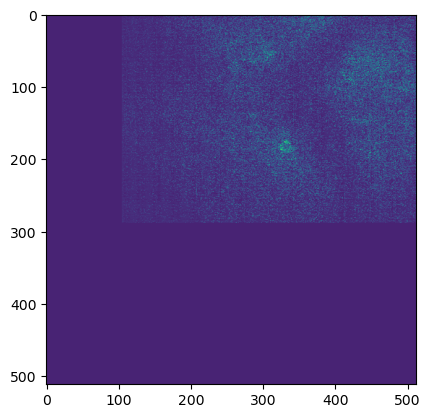

In [564]:
plt.imshow(twop_stack[400,:,:])

(1141.5, 1700.0)

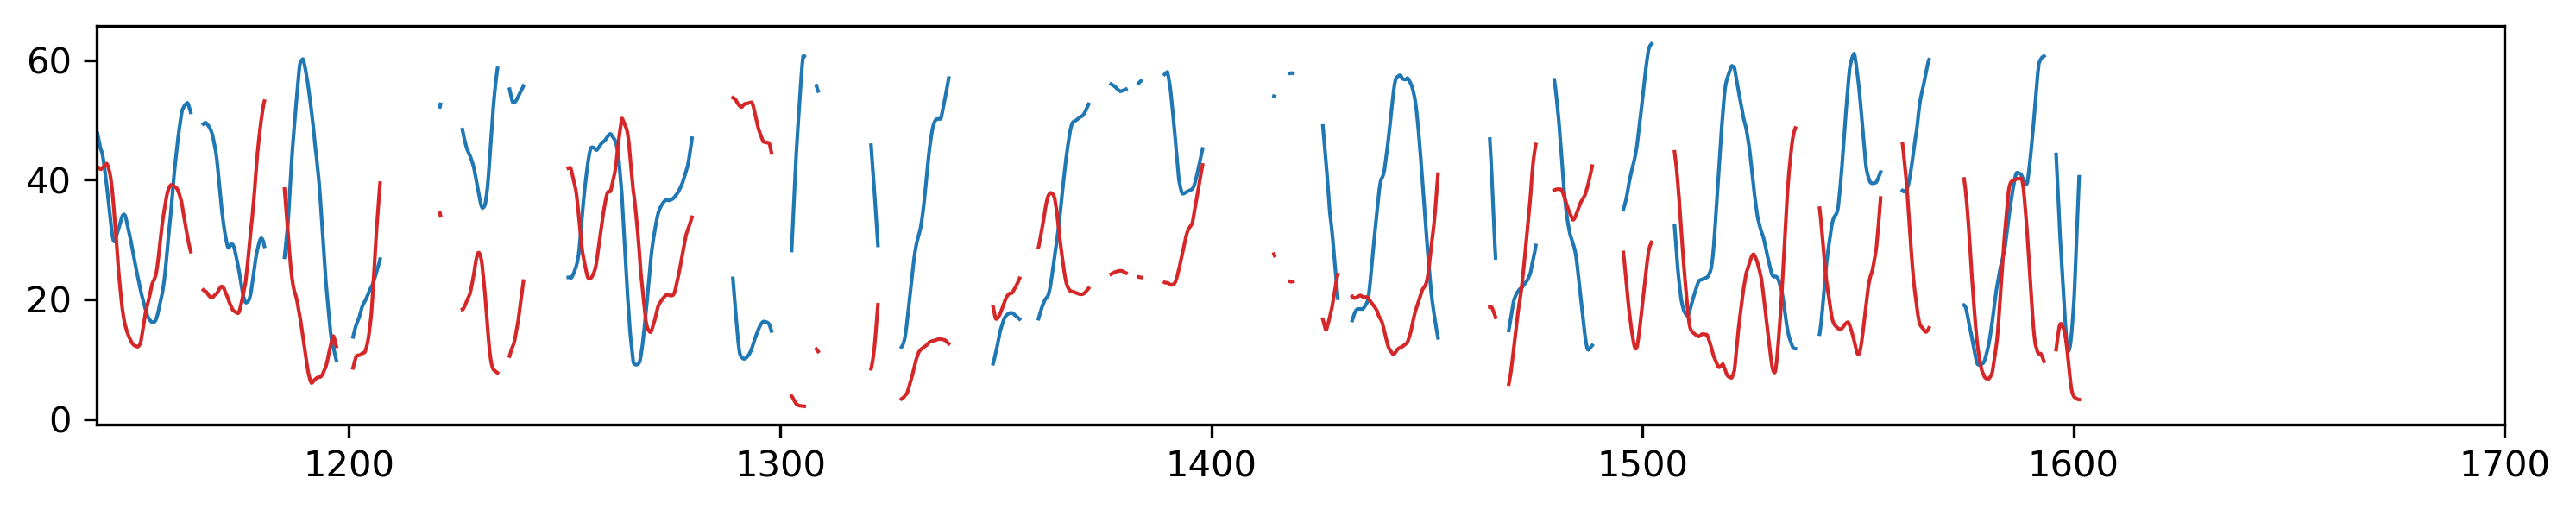

In [592]:
plt.figure(figsize=(12,2), dpi=300)
plt.plot(twopT, top_x/pxls2cm, color='tab:blue', lw=1, label='x')
plt.plot(twopT, top_y/pxls2cm, color='tab:red', lw=1, label='y')
plt.xlim([1141.5,1700])

In [602]:
eyevid[eyeF].shape

(480, 640)

(480.0, 100.0)

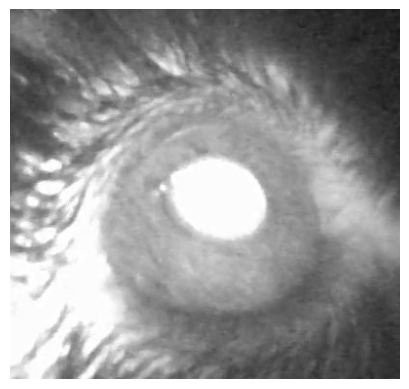

In [603]:
fig, ax = plt.subplots(1, 1)
ax.imshow(eyevid[eyeF], cmap='gray')
ax.axis('off')
ax.set_xlim([100,500])
ax.set_ylim([480,100])

In [640]:
vid_save_path = '250306_DMM_DMM038_demo3.avi'

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_vid = cv2.VideoWriter(vid_save_path, fourcc, 7.5, (3300, 2100))

for f in tqdm(np.arange(start_frame_num, end_frame_num)):

    fig = plt.figure(figsize=(11,7), layout='constrained', dpi=300)
    gs = GridSpec(6,3, figure=fig)

    ax_2p = fig.add_subplot(gs[0:3,0])
    ax_c1 = fig.add_subplot(gs[3,0])
    ax_c2 = fig.add_subplot(gs[4,0])
    ax_c3 = fig.add_subplot(gs[5,0])

    ax_eye = fig.add_subplot(gs[0:3,1])
    ax_theta = fig.add_subplot(gs[3,1])
    ax_phi = fig.add_subplot(gs[4,1])
    ax_puprad = fig.add_subplot(gs[5,1])

    ax_top = fig.add_subplot(gs[0:3,2])
    ax_xy = fig.add_subplot(gs[3,2])
    ax_yaw = fig.add_subplot(gs[4,2])
    ax_ego = fig.add_subplot(gs[5,2])

    scale = 0.5
    ax_top.imshow(topvid[f], cmap='gray', vmin=0, vmax=75)
    ax_top.plot(rearx[f]*scale, reary[f]*scale, '.', color='tab:purple')
    ax_top.plot(learx[f]*scale, leary[f]*scale, '.', color='tab:purple')
    ax_top.axis('off')
    ax_top.plot(830, 515, '*', color='tab:red')
    headx, heady = np.mean([rearx[f]*scale, learx[f]*scale]), np.mean([reary[f]*scale, leary[f]*scale])
    ax_top.plot([headx, headx+250*np.cos(np.deg2rad(yaw[f]))],
                [heady, heady+250*np.sin(np.deg2rad(yaw[f]))],
                '-', lw=2, color='tab:orange')
    ax_top.plot([headx, pillarx], [heady, pillary], '-', lw=2, color='tab:red')
    ax_top.set_xlim([0,1224])
    ax_top.set_ylim([1024,0])

    ax_xy.plot(twopT, top_x/pxls2cm, '.', color='tab:blue', ms=1, label='x')
    ax_xy.plot(twopT, top_y/pxls2cm, '.', color='tab:red', ms=1, label='y')
    ax_xy.set_xlim([320,420])
    ax_xy.set_ylim([0,60])
    ax_xy.legend(fontsize=6)
    ax_xy.vlines(twopT[f], 0, 60, ls='--', color='gray', lw=1)
    ax_xy.set_ylabel('position (cm)')
    ax_xy.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))

    ax_yaw.plot(twopT, yaw, '.', color='tab:orange', ms=1)
    ax_yaw.set_xlim([320,420])
    ax_yaw.set_ylabel('yaw (deg)')
    ax_yaw.set_yticks([0,90,180,270,360])
    ax_yaw.set_ylim([0,360])
    ax_yaw.vlines(twopT[f], 0, 360, ls='--', color='gray', lw=1)
    ax_yaw.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))

    ax_ego.plot(twopT, pillar_ego, '.', color='tab:red', ms=1)
    ax_ego.set_xlim([320,420])
    ax_ego.set_ylabel('egocentric (deg)')
    ax_ego.set_yticks([-180, -90, 0, 90, 180])
    ax_ego.set_ylim([-180,180])
    ax_ego.vlines(twopT[f], -180, 180, ls='--', color='gray', lw=1)
    ax_ego.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))
    ax_ego.set_xlabel('time (s)')

    eyeF, _ = fm2p.find_closest_timestamp(eyeT, twopT[f])

    # ellipse_cent = (int(eye_data['X0'][eyeF]), int(eye_data['Y0'][eyeF]))
    # ellipse_axes = (int(eye_data['longaxis'][eyeF]), int(eye_data['shortaxis'][eyeF]))
    # ellipse_phi = int(np.rad2deg(eye_data['ellipse_phi'][eyeF]))

    # _temp_eye_frame = cv2.ellipse(
    #     eyevid[eyeF],
    #     ellipse_cent,
    #     ellipse_axes,
    #     ellipse_phi,
    #     0, 360, (255,0,0), 2)
    ax_eye.imshow(eyevid[eyeF,:,:], cmap='gray')
    ax_eye.axis('off')
    ax_eye.set_xlim([100,500])
    ax_eye.set_ylim([480,100])
    # pupil_ellipse = patches.Ellipse(
    #     (eye_data['X0'][eyeF], eye_data['Y0'][eyeF]),
    #     eye_data['longaxis'][eyeF],
    #     eye_data['shortaxis'][eyeF],
    #     angle=eye_data['ellipse_phi'][eyeF],
    #     facecolor='none', edgecolor='tab:red'
    # )
    # ax_eye.add_patch(pupil_ellipse)

    ax_theta.plot(twopT, np.rad2deg(theta), 'k.', ms=1)
    ax_theta.set_xlim([320,420])
    ax_theta.set_ylabel('theta (deg)')
    ax_theta.set_ylim([-15, 40])
    ax_theta.vlines(twopT[f], -15, 40, ls='--', color='gray', lw=1)
    ax_theta.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))

    ax_phi.plot(twopT, np.rad2deg(phi), 'k.', ms=1)
    ax_phi.vlines(twopT[f], -45, 15, ls='--', color='gray', lw=1)
    ax_phi.set_xlim([320,420])
    ax_phi.set_ylim([-45, 15])
    ax_phi.set_ylabel('phi (deg)')
    ax_phi.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))

    ax_puprad.plot(twopT, norm(puprad), 'k.', ms=1)
    ax_puprad.set_xlabel('time (s)')
    ax_puprad.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))
    ax_puprad.set_xlim([320,420])
    ax_puprad.set_ylabel('pupil radius (a.u.)')
    ax_puprad.set_ylim([0.25, 1])
    ax_puprad.vlines(twopT[f], 0, 1, ls='--', color='gray', lw=1)

    ax_2p.imshow(twop_stack[f], cmap='gray', vmin=0, vmax=600)
    ax_2p.set_xlim([0,512])
    ax_2p.set_ylim([512,0])
    ax_2p.axis('off')

    ax_c1.plot(twopT, norm(raw_dFF[5,:]), 'k', lw=1)
    ax_c1.set_xlim([320,420])
    ax_c1.set_title('cell 1')
    ax_c1.set_ylim([0,1])
    ax_c1.set_ylabel('norm dF/F')
    ax_c1.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))
    ax_c1.vlines(twopT[f], 0, 1, ls='--', color='gray', lw=1)

    ax_c2.plot(twopT, norm(raw_dFF[2,:]), 'k', lw=1)
    ax_c2.set_xlim([320,420])
    ax_c2.set_title('cell 2')
    ax_c2.set_ylim([0,1])
    ax_c2.set_ylabel('norm dF/F')
    ax_c2.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))
    ax_c2.vlines(twopT[f], 0, 1, ls='--', color='gray', lw=1)

    ax_c3.plot(twopT, norm(raw_dFF[3,:]), 'k', lw=1)
    ax_c3.set_xlim([320,420])
    ax_c3.set_title('cell 3')
    ax_c3.set_ylim([0,1])
    ax_c3.set_ylabel('norm dF/F')
    ax_c3.set_xticks(np.arange(320,445,25), labels=np.arange(0,125,25))
    ax_c3.set_xlabel('time (s)')
    ax_c3.vlines(twopT[f], 0, 1, ls='--', color='gray', lw=1)

    # Save the frame out
    fig.canvas.draw()
    frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    frame_as_array = frame_as_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    img = cv2.cvtColor(frame_as_array, cv2.COLOR_RGB2BGR)
    out_vid.write(img.astype('uint8'))

out_vid.release()


  0%|          | 0/749 [00:00<?, ?it/s]C:\Users\dmartins\AppData\Local\Temp\ipykernel_21940\15216554.py:145: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
C:\Users\dmartins\AppData\Local\Temp\ipykernel_21940\15216554.py:145: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  0%|          | 1/749 [00:00<06:11,  2.01it/s]C:\Users\dmartins\AppData\Local\Temp\ipykernel_21940\15216554.py:145: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
C:\Users\dmartins\AppData\Local\

(320.0, 420.0)

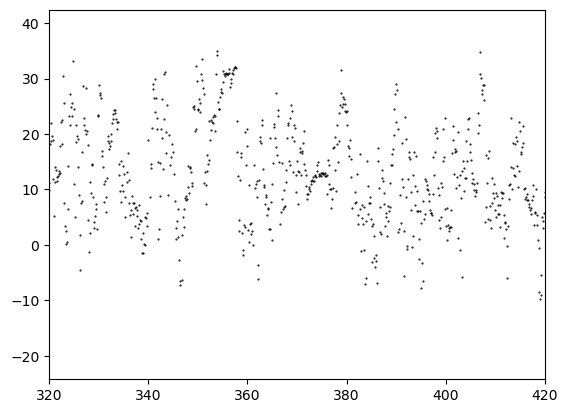

In [637]:
plt.plot(twopT, np.rad2deg(theta), 'k.', ms=1)
plt.xlim([320,420])

In [ ]:
twopT, norm(raw_dFF[3,:])

In [606]:
def tuning_curve(sps, x, x_range):
    """ Calculate tuning curve of neurons to a 1D variable.

    Parameters
    ----------
    sps : np.array
        Spike data. Shape should be (n_cells, n_timepoints).
    x : np.array
        Variable data. Shape should be (n_cells, n_timepoints). The
        timepoints should match those for `sps`, either by interpolation
        or by binning.
    x_range : np.array
        Array of values to bin x into.
    
    Returns
    -------
    var_cent : np.array
        Array of values at the center of each bin. Shape is (n_bins,)
    tuning : np.array
        Array of mean spike counts for each bin. Shape is (n_cells, n_bins).
    tuning_err : np.array
        Array of standard error of the mean spike counts for each bin. Shape
        is (n_cells, n_bins).
    """

    n_cells = np.size(sps,0)

    scatter = np.zeros((n_cells, np.size(x,0)))

    tuning = np.zeros((n_cells, len(x_range)-1))
    tuning_err = tuning.copy()
    var_cent = np.zeros(len(x_range)-1)
    
    for j in range(len(x_range)-1):
        
        var_cent[j] = 0.5*(x_range[j] + x_range[j+1])
    
    for n in range(n_cells):
        
        scatter[n,:] = sps[n,:]
        
        for j in range(len(x_range)-1):
            
            usePts = (x>=x_range[j]) & (x<x_range[j+1])
            
            tuning[n,j] = np.nanmean(scatter[n, usePts])
            
            tuning_err[n,j] = np.nanstd(scatter[n, usePts]) / np.sqrt(np.count_nonzero(usePts))

    return var_cent, tuning, tuning_err

(array([575., 600., 516., 629., 631., 553., 448., 500., 513., 455., 398.,
        457., 481., 565., 574., 508., 509., 573.]),
 array([-180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,  -20.,
           0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.]),
 <BarContainer object of 18 artists>)

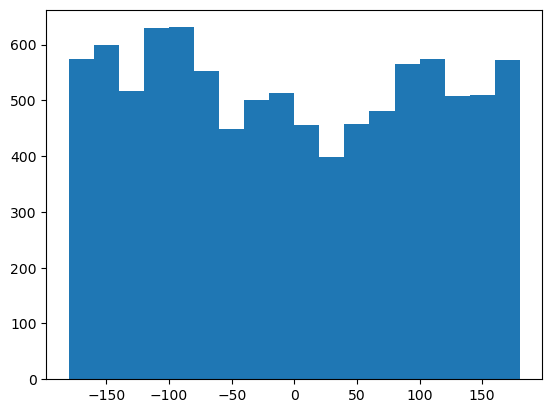

In [612]:
plt.hist(pillar_ego, bins=np.linspace(-180,180,19))

In [613]:
var_cent, tuning, tuning_err = tuning_curve(sps, pillar_ego, np.linspace(-180,180,19))

In [614]:
tuning.shape

(57, 18)

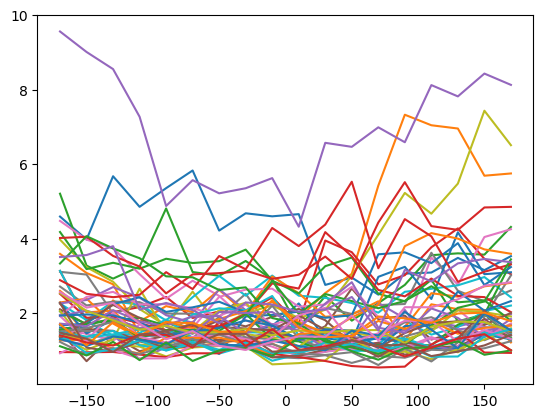

In [620]:
for i in range(np.size(tuning, 0)):
    plt.plot(var_cent, tuning[i,:])

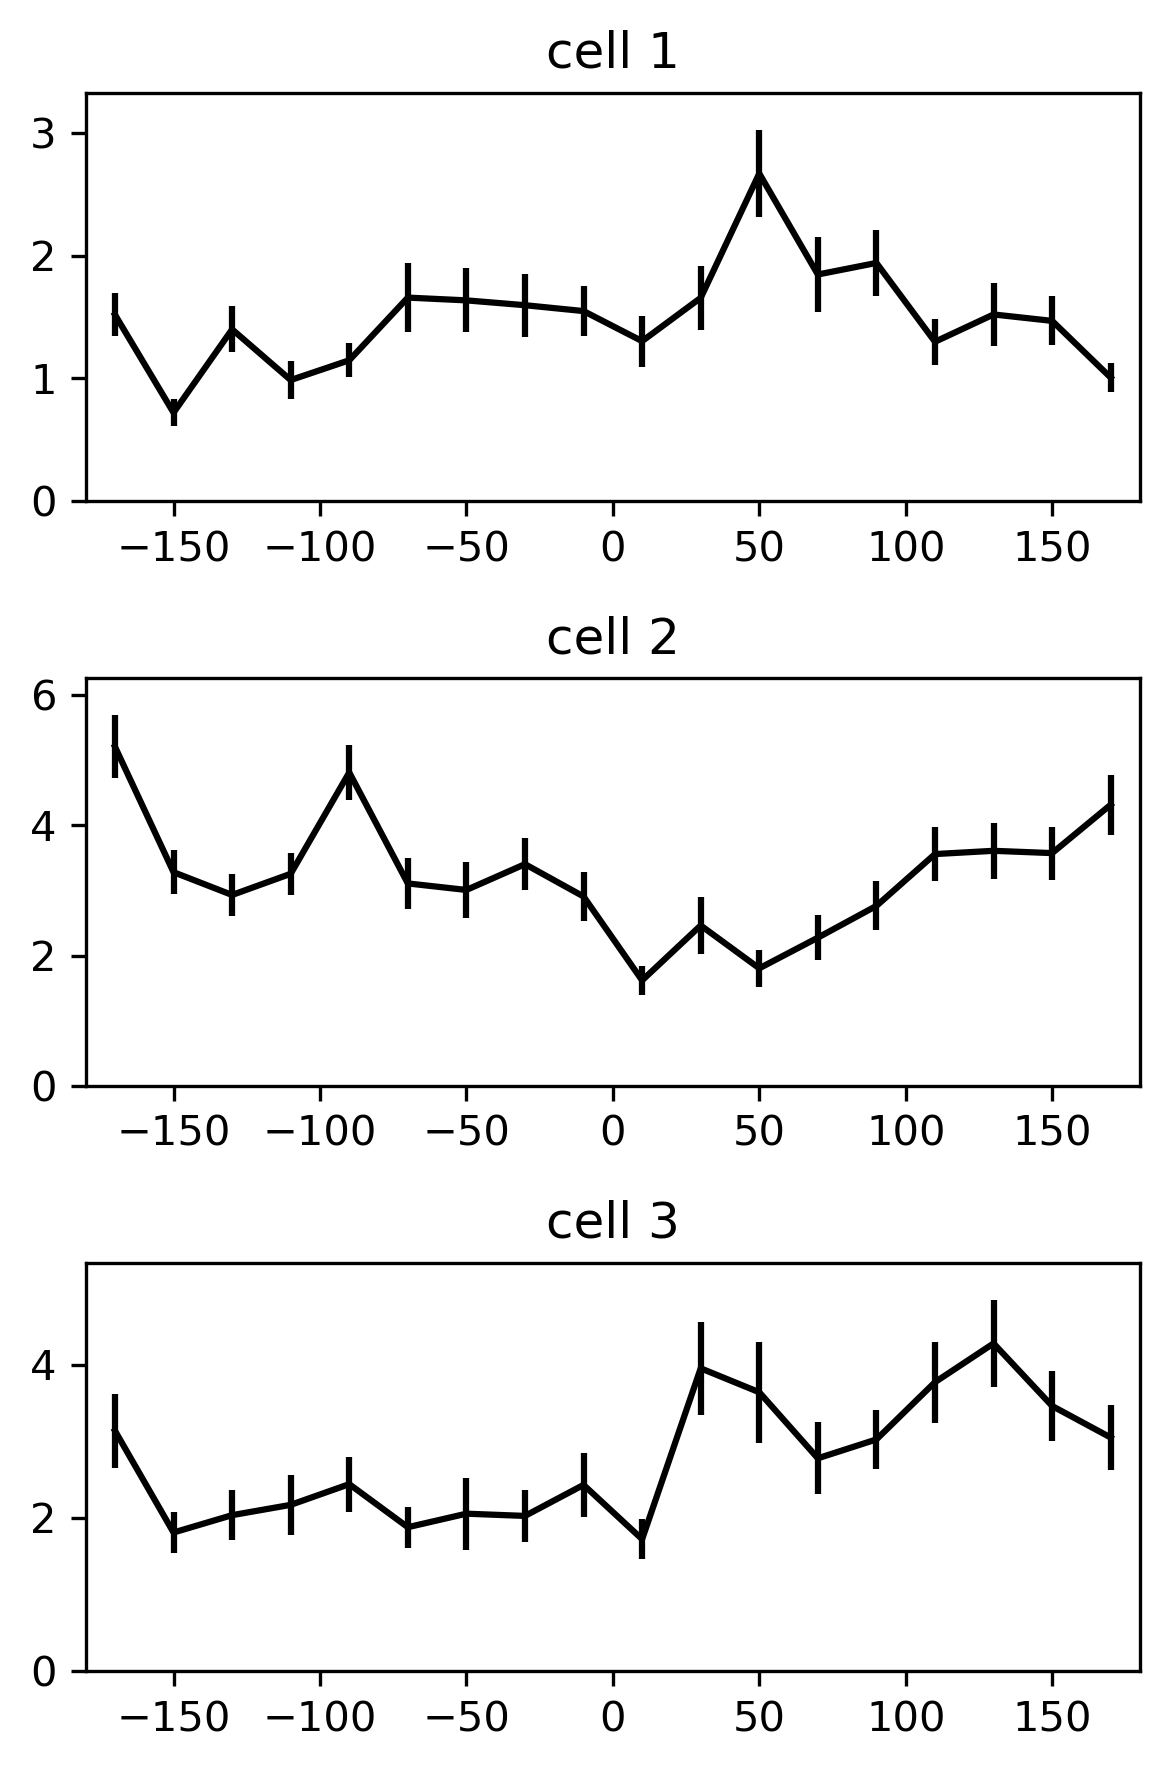

In [632]:
# cells 5, 2, 3
fig, [ax1,ax2,ax3] = plt.subplots(3,1, dpi=300, figsize=(4,6))

ax1.errorbar(var_cent, tuning[5,:], color='k', yerr=tuning_err[5,:])
ax1.set_title('cell 1')
ax1.set_xlim([-180,180])
ax1.set_ylim([0, np.nanmax(tuning[5,:]+tuning_err[5,:])*1.1])

ax2.errorbar(var_cent, tuning[2,:], color='k', yerr=tuning_err[2,:])
ax2.set_title('cell 2')
ax2.set_xlim([-180,180])
ax2.set_ylim([0, np.nanmax(tuning[2,:]+tuning_err[2,:])*1.1])

ax3.errorbar(var_cent, tuning[3,:], color='k', yerr=tuning_err[3,:])
ax3.set_title('cell 3')
ax3.set_xlim([-180,180])
ax3.set_ylim([0, np.nanmax(tuning[3,:]+tuning_err[3,:])*1.1])

fig.tight_layout()